## 파이토치 모델 훈련
- 튜토리얼 영상의 17분 10초

In [1]:
## Import
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root = "./data", train = True,
                                       download = True, transform = transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = 1,
                                         shuffle = True, num_workers = 2)

testset = torchvision.datasets.CIFAR10(root = './data', train = False,
                                      download = True, transform = transform)

testloader = torch.utils.data.DataLoader(testset, batch_size = 1,
                                        shuffle = True, num_workers = 2)

classes = ('plane', 'car', 'bird', 'cat',
          'deer', 'dog', 'froh', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


- 데이터 로더에 있는 결과를 확인하는 방법

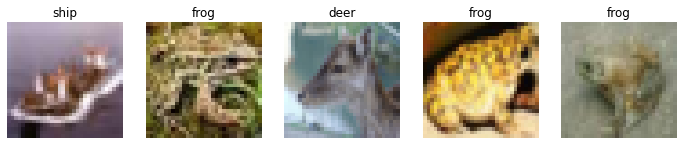

In [3]:
## 시각화 함수 만들기
## 이미지 데이터 시각화
import numpy as np

label_seq = {0:'airplane',
             1:'automobile',
             2:'bird',
             3:'cat',
             4:'deer',
             5:'dog',
             6:'frog',
             7:'horse',
             8:'ship',
             9:'truck'}

plt.figure(figsize = (12, 12))

for i in range(5):
    index = np.random.randint(0, 50000)
    
    img = trainset.data[index,:,:,:]
    label_index = trainset.targets[index]
    label = label_seq[label_index]
    plt.subplot(1,5,i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(label)

plt.show()


- 이제 모델을 훈련시킬 것이다.
- 어디서 본것 같다면, 그건 LeNet의 변형한 모델이라 그렇습니다.
- 이 모델은 앞서 언급한것 처럼 3색(RGB) 이미지를 훈련하는데 적합한 모델로 변형한 모습입니다.

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
net = Net()
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

- 마지막으로 Loss 함수와 옵티마이저를 설정

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum=0.9)

- 로스 함수는 모델이 이상적인 결과물을 예측하기 위한 추론 방법이다.
- 전형적으로 분류 모델들은 CrossEntropyLoss 함수를 사용한다.

- 옵티마이저는 학습 드라이버이다. 여기에서 보다 간단한 최적화 알고리즘 중 하나인 확률적 경사 하강법(SGD(stochastic gradient descent))을 구현하는 최적화 프로그램을 만들었습니다.

- net.parameters()를 통해서 이 알고리즘에 기본적인 파라미터들은 학습률(lr)과 모멘텀의 모든 학습 weight들을 모을 수 있다.

- 마침내, 훈련 루프를 통해서 결합된다.
- 실행하는 데 몇 분 정도 걸릴 수 있으므로 이 셀을 실행하세요.

In [6]:
## 훈련을 2 epoch만 수행
## 즉, 훈련을 2번한다.
for epoch in range(2):
    
    running_loss = 0.0
    
    ## 이 내부 루프에서는 변형된 이미지와 고쳐진 라벨을 
    ## 하나에 배치에 묶어 훈련 데이터 셋을 반복적으로 학습한다.
    for i, data in enumerate(trainloader, 0):
        
        inputs, labels = data
        
        ## Zeroing 그레디언트의 중요한 단계이다.
        ## 그레디언트는 각 배치마다 누적된다.
        ## 만약 모든 배치를 초기화 하지 않는다면,
        ## 그레디언트는 계속해서 축적될 것이고,
        ## 잘 못된 그레디언트 값을 제공받아
        ## 학습이 불가능하게 된다.
        optimizer.zero_grad()
        
        ## 각 배치마다 모델이 예측한다.
        outputs = net(inputs)
        
        ## 실제 값(labels)과 예측 값(outputs) 사이의 차이를
        ## loss값으로 계산한다.
        loss = criterion(outputs, labels)
        
        ## 우리는 학습으로 backward를 통해 그레디언트를 계산한다.
        loss.backward()
        
        ## 옵티마이저는 한번 학습에 step을 수행합니다.
        ## loss 값을 감소 시키는 방향에 있는 학습 가중치를 불러와
        ## backward로 부터 그레디언트를 사용합니다.
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % 
                  (epoch + 1, i + 1, running_loss / 2000))
            
            running_loss = 0.0

print('Finished Training')

/home/bgw2001/anaconda3/envs/py3.8/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,  2000] loss: 2.231
[1,  4000] loss: 2.047
[1,  6000] loss: 1.936
[1,  8000] loss: 1.830
[1, 10000] loss: 1.819
[1, 12000] loss: 1.755
[1, 14000] loss: 1.732
[1, 16000] loss: 1.677
[1, 18000] loss: 1.719
[1, 20000] loss: 1.672
[1, 22000] loss: 1.669
[1, 24000] loss: 1.644
[1, 26000] loss: 1.597
[1, 28000] loss: 1.617
[1, 30000] loss: 1.623
[1, 32000] loss: 1.589
[1, 34000] loss: 1.615
[1, 36000] loss: 1.584
[1, 38000] loss: 1.590
[1, 40000] loss: 1.577
[1, 42000] loss: 1.536
[1, 44000] loss: 1.570
[1, 46000] loss: 1.538
[1, 48000] loss: 1.564
[1, 50000] loss: 1.565
[2,  2000] loss: 1.493
[2,  4000] loss: 1.515
[2,  6000] loss: 1.490
[2,  8000] loss: 1.532
[2, 10000] loss: 1.536
[2, 12000] loss: 1.496
[2, 14000] loss: 1.466
[2, 16000] loss: 1.495
[2, 18000] loss: 1.535
[2, 20000] loss: 1.534
[2, 22000] loss: 1.496
[2, 24000] loss: 1.532
[2, 26000] loss: 1.537
[2, 28000] loss: 1.485
[2, 30000] loss: 1.546
[2, 32000] loss: 1.496
[2, 34000] loss: 1.510
[2, 36000] loss: 1.554
[2, 38000] 

- 손실은 단조롭게 내림차순이며, 이는 우리 모델이 훈련 데이터 세트에 대한 성능을 계속 개선하고 있음을 나타냅니다.
- 마지막 단계로 우리는 모델이 단순히 데이터 세트를 "암기"하는 것이 아니라 실제로 일반 학습을 수행하는지 확인해야 합니다.
- 이를 과적합이라고 하며 일반적으로 데이터 세트가 너무 작거나(일반 학습에 대한 예제가 충분하지 않음) 모델에 데이터 세트를 올바르게 모델링하는 데 필요한 것보다 더 많은 학습 매개변수가 있음을 나타냅니다.
- 이것이 데이터 세트가 훈련 및 테스트 데이터 셋으로 분할되는 이유입니다.- 모델의 일반화를 테스트하기 위해 훈련하지 않은 데이터(처음보는 데이터)에 대한 예측을 수행하도록 요청합니다.

In [7]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 46 %


- 모델의 정확도가 대략 50%임을 알 수 있습니다.
- 이것은 모델에서 일부 일반적인 학습이 발생했음을 보여줍니다.